In [2]:
import pandas as pd
from platform import python_version
from pyspark.context import SparkContext
sc = SparkContext.getOrCreate()
from operator import add
from pyspark.sql import SparkSession
app_names = "ReadJSON, ReadCSV"
spark = SparkSession.builder.appName(app_names).getOrCreate()
import matplotlib.pyplot as plt
from wordcloud import WordCloud  # Import WordCloud class
from pyspark.sql.functions import explode, col, lit
from pyspark.sql.functions import when
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 33, 7, Finished, Available)

# Lyrics Data

In [4]:
rdd = sc.textFile("azureml://subscriptions/9c10b96a-fdb2-42f1-8aab-4b10d7dfafb4/resourcegroups/halpagu-MLRG/workspaces/halpagu-MLworkspace/datastores/workspaceblobstore/paths/UI/2023-12-23_213418_UTC/lyrics.jl")



rdd.take(10)

StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 33, 9, Finished, Available)

['{"song": "Kendrick-lamar-swimming-pools-drank-lyrics", "lyrics": "\\n\\n[Produced by T-Minus]\\n\\n[Intro]\\nPour up (Drank), head shot (Drank)\\nSit down (Drank), stand up (Drank)\\nPass out (Drank), wake up (Drank)\\nFaded (Drank), faded (Drank)\\n\\n[Verse 1]\\nNow I done grew up \'round some people livin\' their life in bottles\\nGranddaddy had the golden flask\\nBackstroke every day in Chicago\\nSome people like the way it feels\\nSome people wanna kill their sorrows\\nSome people wanna fit in with the popular, that was my problem\\nI was in a dark room, loud tunes\\nLookin\' to make a vow soon\\nThat I\'ma get fucked up, fillin\' up my cup I see the crowd mood\\nChangin\' by the minute and the record on repeat\\nTook a sip, then another sip, then somebody said to me\\n\\n[Chorus]\\nNigga, why you babysittin\' only two or three shots?\\nI\'ma show you how to turn it up a notch\\nFirst you get a swimming pool full of liquor, then you dive in it\\nPool full of liquor, then you div

# Cleaning Data and Counting Song Lyrics Words

In [5]:
import json
import re

# Assuming you have an RDD named 'rdd' with JSON data

# Step 1: Convert JSON records to Python dictionaries
rdd2 = rdd.map(lambda x: json.loads(x))

# Step 2: Split lyrics into words and create a new dictionary
def split_vocabulary(dictionary):
    lyrics = dictionary.get('lyrics', '')  # Get the 'lyrics' field from the dictionary
    # Remove all characters that are not words, numbers, underscores, or spaces
    cleaned_lyrics = re.sub(r'[^\w\s]', '', lyrics)
    
    # Split the cleaned lyrics into words
    words = re.split(r'[;,*\n\s()\[\]\'":—-]+|(?<=--)|(?=--)', cleaned_lyrics)
    words = [word.lower() for word in words if word.strip()]
    

    return {'song': dictionary.get('song', ''), 'vocabulary': words}

# Step 3: Apply the split_vocabulary function to each dictionary
rdd_with_vocabulary = rdd2.map(split_vocabulary)

# Step 4: Take the first 10 records from the transformed RDD
first_10_records = rdd_with_vocabulary.take(10)

# Display the first 10 records
for record in first_10_records:
    print(record)



StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 33, 10, Finished, Available)

{'song': 'Kendrick-lamar-swimming-pools-drank-lyrics', 'vocabulary': ['produced', 'by', 'tminus', 'intro', 'pour', 'up', 'drank', 'head', 'shot', 'drank', 'sit', 'down', 'drank', 'stand', 'up', 'drank', 'pass', 'out', 'drank', 'wake', 'up', 'drank', 'faded', 'drank', 'faded', 'drank', 'verse', '1', 'now', 'i', 'done', 'grew', 'up', 'round', 'some', 'people', 'livin', 'their', 'life', 'in', 'bottles', 'granddaddy', 'had', 'the', 'golden', 'flask', 'backstroke', 'every', 'day', 'in', 'chicago', 'some', 'people', 'like', 'the', 'way', 'it', 'feels', 'some', 'people', 'wanna', 'kill', 'their', 'sorrows', 'some', 'people', 'wanna', 'fit', 'in', 'with', 'the', 'popular', 'that', 'was', 'my', 'problem', 'i', 'was', 'in', 'a', 'dark', 'room', 'loud', 'tunes', 'lookin', 'to', 'make', 'a', 'vow', 'soon', 'that', 'ima', 'get', 'fucked', 'up', 'fillin', 'up', 'my', 'cup', 'i', 'see', 'the', 'crowd', 'mood', 'changin', 'by', 'the', 'minute', 'and', 'the', 'record', 'on', 'repeat', 'took', 'a', 'sip

In [6]:
def count_words_in_dictionary(dictionary):
    vocabulary = dictionary.get('vocabulary', [])  # Get the 'vocabulary' list or an empty list if not present
    word_counts = {}
    
    for word in vocabulary:
        word_counts[word] = word_counts.get(word, 0) + 1  # Count word occurrences
    
    return {'song': dictionary.get('song', ''), 'word_counts': word_counts}

# Apply the function to your RDD containing dictionaries with 'vocabulary'
rdd_with_word_counts = rdd_with_vocabulary.map(count_words_in_dictionary)

# Take the first 10 records from the transformed RDD
rdd_with_word_counts.take(10)


StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 33, 11, Finished, Available)

[{'song': 'Kendrick-lamar-swimming-pools-drank-lyrics',
  'word_counts': {'produced': 1,
   'by': 3,
   'tminus': 1,
   'intro': 1,
   'pour': 4,
   'up': 25,
   'drank': 32,
   'head': 4,
   'shot': 4,
   'sit': 4,
   'down': 5,
   'stand': 4,
   'pass': 4,
   'out': 8,
   'wake': 7,
   'faded': 8,
   'verse': 3,
   '1': 1,
   'now': 4,
   'i': 32,
   'done': 1,
   'grew': 1,
   'round': 1,
   'some': 5,
   'people': 4,
   'livin': 1,
   'their': 2,
   'life': 2,
   'in': 22,
   'bottles': 4,
   'granddaddy': 1,
   'had': 2,
   'the': 21,
   'golden': 1,
   'flask': 1,
   'backstroke': 1,
   'every': 1,
   'day': 1,
   'chicago': 1,
   'like': 2,
   'way': 1,
   'it': 17,
   'feels': 1,
   'wanna': 5,
   'kill': 1,
   'sorrows': 1,
   'fit': 1,
   'with': 1,
   'popular': 1,
   'that': 14,
   'was': 3,
   'my': 5,
   'problem': 1,
   'a': 17,
   'dark': 1,
   'room': 1,
   'loud': 1,
   'tunes': 1,
   'lookin': 1,
   'to': 8,
   'make': 1,
   'vow': 1,
   'soon': 2,
   'ima': 9,
   'g

# Lyrics positive and negative emotion classification
# Custom Lexicon-Based, Vader, and TextBlob Sentiment Analysis 

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col
from pyspark.sql.types import StringType
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from textblob import TextBlob


# Define your stopwords
STOPWORDS = ['', 'a', '*', 'and', 'is', 'of', 'the', '\n\n', '\n', 'by', '[', ']', '(', ')','as','it','my','was','for','gon',
             'that','had','in','or','on','i','your',"i'm",'at','you','to','then','just','it','it,','me','can','we','with',
             'she','her','he','his','up','get','got','-','–','—','--','!','/','our','are','me','with','going',"it's",'by:','9,','still','2015:',
            "don't","(it's","on,",'i’m','these','•','j','s','m','d','?',"i", "the", "you", "in", "a", "and", "it", "that", "to", "of", "is", "me",
            "this", "all", "out", "like", "im", "do", "dont", "be", "was", "they", "how", "are", "for", "have", "not", "with", "at", "on", "if", "my", "up",
            "your", "then", "we", "as", "but", "so", "or", "an", "am", "by", "can","from", "just", "what", "he", "him", "his", "her", "she", "our", "us","their",
            "who", "them", "got", "yeah", "know", "when", "thats", "say","its", "where", "had", "see", "look", "now", "take", "tell", "no","get","1","2","3",
            "there","na","oh","uh","la","beyoncé","john","de","ты","woo","aw","les","и",'one']

sentiment_lexicon = {
    'positive': ['good', 'happy', 'joy', 'excellent','love','fun','glow','dans'],
    'negative': ['bad', 'sad', 'hate', 'terrible','shit','fuck','bitch','nigga','devil','beat','shoot','niggas',
                 'fucking','victim','dirty','beat','sick','never','kill']
}

# Create a Spark DataFrame from the RDD
spark = SparkSession.builder.getOrCreate()
df = spark.createDataFrame(rdd_with_word_counts)

# Flatten the 'word_counts' dictionary into separate columns
df = df.select("song", "word_counts")

# Use the explode function to split the 'word_counts' dictionary into separate rows
df = df.select("song", explode("word_counts").alias("word", "count"))

# Filter out stopwords
df = df.filter(~col("word").isin(STOPWORDS))

sia = SentimentIntensityAnalyzer()

@udf(StringType())
def classify_sentiment(word):
    if word in sentiment_lexicon['positive']:
        return 'positive'
    elif word in sentiment_lexicon['negative']:
        return 'negative'
    else:
        return 'neutral'

@udf(StringType())
def classify_sentiment_vader(text):
    sentiment_score = sia.polarity_scores(text)['compound']
    
    if sentiment_score >= 0.05:
        return 'positive'
    elif sentiment_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

@udf(StringType())
def classify_sentiment_textblob(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity

    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'


# Apply VADER sentiment analysis UDF
df = df.withColumn("sentiment_vader", classify_sentiment_vader(col("word")))
df = df.withColumn("sentiment", classify_sentiment(col("word")))
df = df.withColumn("sentiment_textblob", classify_sentiment_textblob(col("word")))

# Group by Song and calculate sentiment counts
song_sentiment_vader = df.groupBy("song", "sentiment_vader").sum("count").groupBy("song").pivot("sentiment_vader", ["positive", "negative", "neutral"]).sum("sum(count)").fillna(0)
song_sentiment = df.groupBy("song", "sentiment").sum("count").groupBy("song").pivot("sentiment", ["positive", "negative", "neutral"]).sum("sum(count)").fillna(0)

song_sentiment_vader = song_sentiment_vader.withColumnRenamed("positive", "positive_count_vader").withColumnRenamed("negative", "negative_count_vader").withColumnRenamed("neutral", "neutral_count_vader")
song_sentiment = song_sentiment.withColumnRenamed("positive", "positive_count").withColumnRenamed("negative", "negative_count").withColumnRenamed("neutral", "neutral_count")

# Calculate final sentiment based on counts
song_sentiment_vader = song_sentiment_vader.withColumn("final_sentiment_vader", when(song_sentiment_vader["positive_count_vader"] > song_sentiment_vader["negative_count_vader"], "positive").otherwise("negative"))
song_sentiment = song_sentiment.withColumn("final_sentiment", when(song_sentiment["positive_count"] > song_sentiment["negative_count"], "positive").otherwise("negative"))

# Join sentiment information back with the original DataFrame
df = df.join(song_sentiment_vader.select("song", "final_sentiment_vader","positive_count_vader","negative_count_vader"), on="song", how="left") \
    .join(song_sentiment.select("song", "final_sentiment","positive_count","negative_count"), on="song", how="left")

# Show the updated DataFrame
df.show()

StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 33, 12, Finished, Available)

[nltk_data] Downloading package vader_lexicon to /home/trusted-
[nltk_data]     service-user/nltk_data...


+--------------------+---------+-----+---------------+---------+------------------+---------------------+--------------------+--------------------+---------------+--------------+--------------+
|                song|     word|count|sentiment_vader|sentiment|sentiment_textblob|final_sentiment_vader|positive_count_vader|negative_count_vader|final_sentiment|positive_count|negative_count|
+--------------------+---------+-----+---------------+---------+------------------+---------------------+--------------------+--------------------+---------------+--------------+--------------+
|6ix9ine-mooky-lyrics|benjamins|    1|        neutral|  neutral|           neutral|             negative|                   2|                  21|       negative|             0|            39|
|6ix9ine-mooky-lyrics|     bout|    2|        neutral|  neutral|           neutral|             negative|                   2|                  21|       negative|             0|            39|
|6ix9ine-mooky-lyrics|     hal

# Compare Custom Lexicon-Based, Vader, and TextBlob Sentiment Analysis

StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 18, 13, Finished, Available)

+---------------+-------+
|sentiment_vader|  count|
+---------------+-------+
|       positive| 357418|
|        neutral|5331977|
|       negative| 477689|
+---------------+-------+

+------------------+-------+
|sentiment_textblob|  count|
+------------------+-------+
|          positive| 330288|
|           neutral|5547792|
|          negative| 289004|
+------------------+-------+

+---------+-------+
|sentiment|  count|
+---------+-------+
| positive|  29922|
|  neutral|5997765|
| negative| 139397|
+---------+-------+



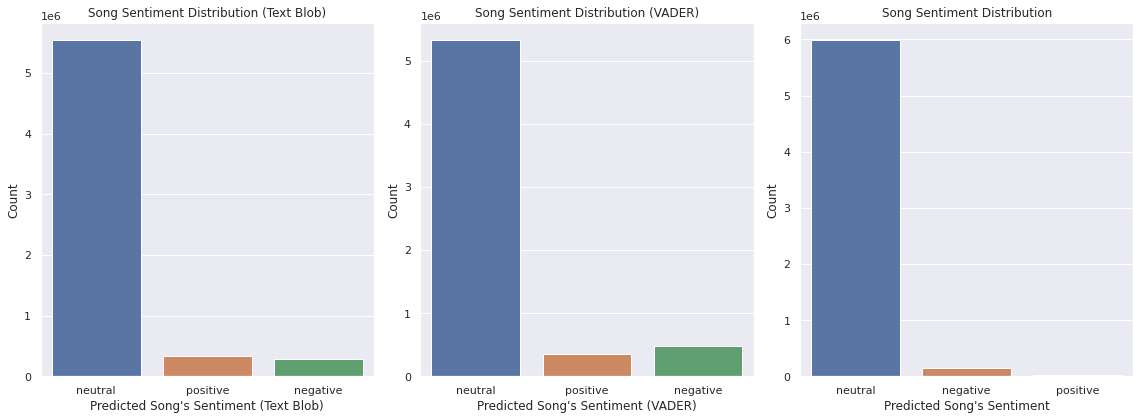

In [8]:
# Import the necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the value counts of the "sentiment_vader" column
value_counts_vader = df.select('sentiment_vader').groupBy('sentiment_vader').count()

# Show the value counts
value_counts_vader.show()

# Calculate the value counts of the "sentiment_textblob" column
value_counts_textblob = df.select('sentiment_textblob').groupBy('sentiment_textblob').count()

# Show the value counts
value_counts_textblob.show()

# Calculate the value counts of the "sentiment" column
value_counts_sentiment = df.select('sentiment').groupBy('sentiment').count()

# Show the value counts
value_counts_sentiment.show()

# Create subplots using Seaborn and Matplotlib
sns.set(style="darkgrid")

# Set up the figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

# Plot for sentiment_textblob
sns.countplot(data=df.toPandas(), x="sentiment_textblob", ax=axes[0])
axes[0].set_xlabel("Predicted Song's Sentiment (Text Blob)")
axes[0].set_ylabel("Count")
axes[0].set_title("Song Sentiment Distribution (Text Blob)")

# Plot for sentiment_vader
sns.countplot(data=df.toPandas(), x="sentiment_vader", ax=axes[1])
axes[1].set_xlabel("Predicted Song's Sentiment (VADER)")
axes[1].set_ylabel("Count")
axes[1].set_title("Song Sentiment Distribution (VADER)")

# Plot for sentiment
sns.countplot(data=df.toPandas(), x="sentiment", ax=axes[2])
axes[2].set_xlabel("Predicted Song's Sentiment")
axes[2].set_ylabel("Count")
axes[2].set_title("Song Sentiment Distribution")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


# Exploring Sentimental Tones in American Song Lyrics: An Analysis of Positive and Negative Emotion Distribution

StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 31, 11, Finished, Available)

+---------------------+-------+
|final_sentiment_vader|  count|
+---------------------+-------+
|             positive|1619888|
|             negative|4547196|
+---------------------+-------+



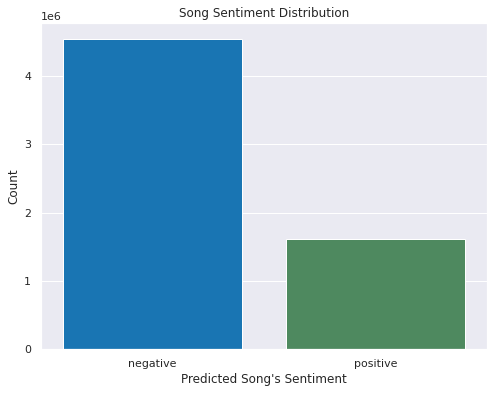

In [6]:
# Import the necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the value counts of the "final_sentiment_vader" column
value_counts = df.select('final_sentiment_vader').groupBy('final_sentiment_vader').count().alias("Predicted Song's Sentiment")

# Show the value counts
value_counts.show()

# Define a custom color palette
custom_palette = ["#007acc","#44935b"]  # You can customize the colors

# Create a countplot using Seaborn with the custom color palette
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(data=df.toPandas(), x="final_sentiment_vader", palette=custom_palette)
plt.xlabel("Predicted Song's Sentiment")
plt.ylabel("Count")
plt.title("Song Sentiment Distribution")
plt.show()


StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 22, 12, Finished, Available)

+---------------+-------+
|sentiment_vader|  count|
+---------------+-------+
|       positive| 357418|
|        neutral|5331977|
|       negative| 477689|
+---------------+-------+



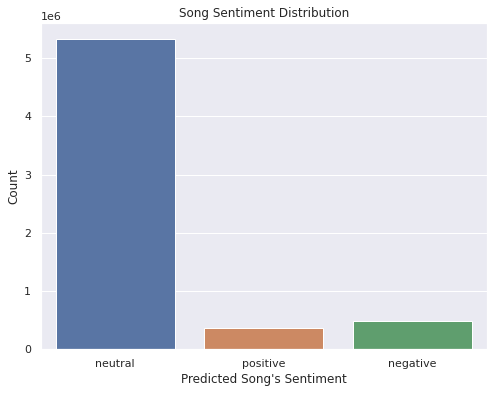

In [7]:
# Import the necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the value counts of the "final_sentiment_vader" column
value_counts = df.select('sentiment_vader').groupBy('sentiment_vader').count()

# Show the value counts
value_counts.show()

# Create a countplot using Seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(data=df.toPandas(), x="sentiment_vader")
plt.xlabel("Predicted Song's Sentiment")
plt.ylabel("Count")
plt.title("Song Sentiment Distribution")
plt.show()

# Word Cloud Analysis of American Song Lyrics

In [14]:

# Convert DataFrame to a dictionary of word frequencies
word_frequency_data = dict(zip(df.select("word").rdd.flatMap(lambda x: x).collect(), df.select("count").rdd.flatMap(lambda x: x).collect()))

# Create a WordCloud instance and configure it
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_frequency_data)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 33, 19, Finished, Available)

AttributeError: 'TransposedFont' object has no attribute 'getbbox'

# Exploring Word Frequencies: Top 15 Words in American Song Lyrics

StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 31, 12, Finished, Available)

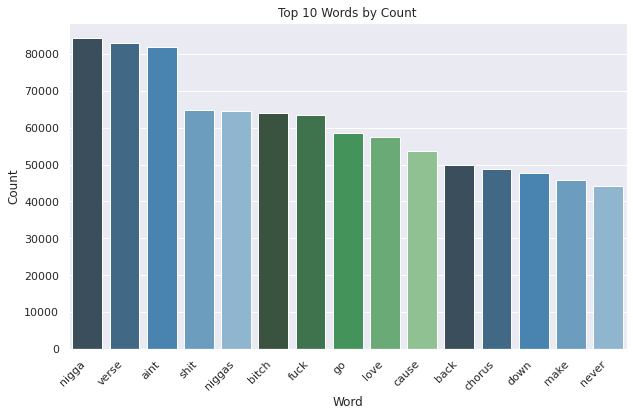

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Assuming you have a DataFrame with columns 'word', 'count'
word_counts = df.groupBy("word").sum("count").withColumnRenamed("sum(count)", "count").orderBy("count", ascending=False)

# Select the top 10 words with the highest counts
top_10_words = word_counts.limit(15).toPandas()

# Set the style and create a figure
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

# Use a combination of "Blues" and "Greens" palettes with more shades and a reversed order for darkness
blue_green_palette = sns.color_palette("Blues_d", 5)[::-1] + sns.color_palette("Greens_d", 5)[::-1]

# Create a bar chart with the custom dark blue-green palette
sns.barplot(data=top_10_words, x="word", y="count", palette=blue_green_palette)

plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Top 10 Words by Count")
plt.xticks(rotation=45, ha="right")

plt.show()  # Display the bar chart


# Song Data

In [15]:
from pyspark.sql.functions import col, when, array_contains
from pyspark.sql import SparkSession
from pyspark.sql.functions import month, dayofmonth, when
from pyspark.sql.functions import to_date

spark = SparkSession.builder.appName("ReadJSON").config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()
spark = SparkSession.builder.appName("ReadJSON").getOrCreate()

df_songinfo = spark.read.json("azureml://subscriptions/9c10b96a-fdb2-42f1-8aab-4b10d7dfafb4/resourcegroups/halpagu-MLRG/workspaces/halpagu-MLworkspace/datastores/workspaceblobstore/paths/UI/2023-12-23_213418_UTC/song_info.json")

df_songinfo = df_songinfo.withColumn(
    'tags',
    when(
        (array_contains(col('tags'), 'Rap') & array_contains(col('tags'), 'Pop')) |
        (array_contains(col('tags'), 'Rock') & array_contains(col('tags'), 'Heavy Metal')) |
        (array_contains(col('tags'), 'Rock') & array_contains(col('tags'), 'R&B')) |
        (array_contains(col('tags'), 'Jazz') & array_contains(col('tags'), 'R&B')) |
        (array_contains(col('tags'), 'Electronic') & array_contains(col('tags'), 'R&B')) |
        (array_contains(col('tags'), 'K-Pop') & array_contains(col('tags'), 'R&B')), 'Mix'
    )
    .when(array_contains(col('tags'), 'Rap'), 'Rap')
    .when(array_contains(col('tags'), 'Pop'), 'Pop')
    .when(array_contains(col('tags'), 'R&B'), 'R&B')
    .when(array_contains(col('tags'), 'Rock'), 'Rock')
    .when(array_contains(col('tags'), 'Jazz'), 'Jazz')
    .when(array_contains(col('tags'), "K-Pop (케이팝)"), 'K-Pop')
    .when(array_contains(col('tags'), 'Heavy Metal'), 'Heavy Metal')
    .when(array_contains(col('tags'), 'Electronic'), 'Electronic')
    .otherwise('Non-Music')
)

# Extract month and day from the release_date
df_songinfo = df_songinfo.withColumn("release_date", to_date(col("release_date"), "MMMM dd, yyyy"))
df_songinfo = df_songinfo.filter(col("release_date").isNotNull())
df_songinfo = df_songinfo.withColumn("month", month(col("release_date")))

# Create a new column for seasons based on the month and day
df_songinfo = df_songinfo.withColumn(
    "season",
    when((col("month") >= 3) & (col("month") <= 5), "Spring")
    .when((col("month") >= 6) & (col("month") <= 8), "Summer")
    .when((col("month") >= 9) & (col("month") <= 11), "Fall")
    .otherwise("Winter")
)

# Select relevant columns including the new "season" column
df_songinfo = df_songinfo.select("url_name", "title", "primary_artist", "release_date", "views", "tags", "season")

# Show the resulting DataFrame
df_songinfo.show()


StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 33, 20, Finished, Available)

+--------------------+--------------------+--------------+------------+--------+----+------+
|            url_name|               title|primary_artist|release_date|   views|tags|season|
+--------------------+--------------------+--------------+------------+--------+----+------+
|Kendrick-lamar-sw...|Swimming Pools (D...|Kendrick-lamar|  2012-07-31| 5589280| Rap|Summer|
|Kendrick-lamar-mo...|         Money Trees|Kendrick-lamar|  2012-10-22| 4592003| Rap|  Fall|
|Kendrick-lamar-xx...|                XXX.|Kendrick-lamar|  2017-04-14| 4651514| Mix|Spring|
|A-ap-rocky-fuckin...|    Fuckin’ Problems|    A-ap-rocky|  2012-10-24| 7378309| Rap|  Fall|
|Kendrick-lamar-dn...|                DNA.|Kendrick-lamar|  2017-04-14| 5113687| Rap|Spring|
|Kendrick-lamar-po...|      Poetic Justice|Kendrick-lamar|  2012-10-22| 4137688| Rap|  Fall|
|Kendrick-lamar-bi...|Bitch, Don’t Kill...|Kendrick-lamar|  2012-10-22| 4455762| Rap|  Fall|
|Kendrick-lamar-ki...|          King Kunta|Kendrick-lamar|  2015-03-15

# Combining song data and lyric data

In [16]:
from pyspark.sql.functions import col

# Join df_resultt and df_songinfo and select the desired columns
filtered_df = df.join(df_songinfo, df['song'] == df_songinfo['url_name'], 'inner').select(df_songinfo['primary_artist'],df['song'],df['final_sentiment_vader'],df['positive_count_vader'],df['negative_count_vader'],df_songinfo['release_date'],df['word'],df['count'],df_songinfo['views'],df_songinfo['tags'],df_songinfo['season'])


filtered_df = filtered_df.orderBy(col('count').desc())
filtered_df.show()


StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 33, 21, Finished, Available)

+--------------------+--------------------+---------------------+--------------------+--------------------+------------+-------+-----+------+----+------+
|      primary_artist|                song|final_sentiment_vader|positive_count_vader|negative_count_vader|release_date|   word|count| views|tags|season|
+--------------------+--------------------+---------------------+--------------------+--------------------+------------+-------+-----+------+----+------+
|           Daft-punk|Daft-punk-lose-yo...|             negative|                  14|                  46|  2013-08-13|   come|  320|337798| Pop|Summer|
|               Buddy|  Buddy-black-lyrics|             negative|                   4|                  28|  2018-07-20|  black|  232| 55931| Rap|Summer|
|            Skrillex|Skrillex-summit-l...|             positive|                   4|                   0|  2013-01-02|breathe|  204| 22925|Rock|Winter|
|            Lil-pump|Lil-pump-gucci-ga...|             negative|           

# Artist Data

In [17]:
rd_artistinfo = spark.read.json("azureml://subscriptions/9c10b96a-fdb2-42f1-8aab-4b10d7dfafb4/resourcegroups/halpagu-MLRG/workspaces/halpagu-MLworkspace/datastores/workspaceblobstore/paths/UI/2023-12-23_213418_UTC/artist_info.json")
rd_artistinfo.show()

StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 33, 22, Finished, Available)

+---------+-----+--------------------+--------------------+------------------+
|followers|   iq|               roles|               songs|          url_name|
+---------+-----+--------------------+--------------------+------------------+
|       15|    0|                  []|[Post-malone-rock...|        Mike-bozzi|
|     4902|  175|   [Verified Artist]|[Beyonce-drunk-in...|             Jay-z|
|     9313|25492|[Verified Artist,...|[A-ap-rocky-fucki...|        A-ap-rocky|
|       46|    0|                  []|[Nf-let-you-down-...|    Tommee-profitt|
|        3|    0|                  []|[Sam-smith-too-go...|   Capitol-records|
|        7|    0|                  []|[Drake-hotline-bl...|      Chris-athens|
|       24|    0|                  []|[Andy-mineo-uncom...|  Joseph-prielozny|
|      247|    0|                  []|[Drake-nice-for-w...|  Ol-dirty-bastard|
|     5431| 3873|[Verified Artist,...|[Drake-in-my-feel...|         Lil-wayne|
|     1092| 2118|[Verified Artist,...|[Pusha-t-noset

# Combining Merge data and artist data

In [18]:
filtered_df = filtered_df.join(rd_artistinfo, filtered_df['primary_artist'] == rd_artistinfo['url_name'], 'inner').select(filtered_df['primary_artist'],filtered_df['song'],filtered_df['final_sentiment_vader'],filtered_df['release_date'],filtered_df['tags'],filtered_df['season'],filtered_df['views'],rd_artistinfo['followers'])

filtered_df = filtered_df.dropDuplicates()

filtered_df = filtered_df.orderBy(col('count').desc())
filtered_df.show()

StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 33, 23, Finished, Available)

+-----------------+--------------------+---------------------+------------+----+------+------+---------+
|   primary_artist|                song|final_sentiment_vader|release_date|tags|season| views|followers|
+-----------------+--------------------+---------------------+------------+----+------+------+---------+
|          Rihanna|Rihanna-goodnight...|             negative|  2016-01-28| Pop|Winter|121689|     4551|
|        Daft-punk|Daft-punk-around-...|             negative|  1997-01-20| Pop|Winter| 56205|      606|
|               Yc|     Yc-racks-lyrics|             negative|  2011-04-05| Rap|Spring| 84945|        2|
|        Daft-punk|Daft-punk-superhe...|             negative|  2001-02-26|Rock|Winter| 12487|      606|
|          Beyonce|Beyonce-creole-ly...|             negative|  2006-09-04| Pop|  Fall|  9591|     3081|
|           Halsey|Halsey-dont-play-...|             positive|  2017-06-02| Pop|Summer|191750|     1784|
|         2-chainz|2-chainz-its-a-vi...|             ne

StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 31, 39, Finished, Available)

+---------------------+-----+
|final_sentiment_vader|count|
+---------------------+-----+
|             positive|10361|
|             negative|23273|
+---------------------+-----+



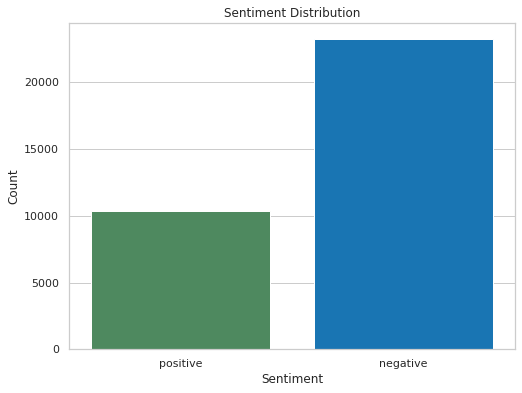

In [34]:
# Import the necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the value counts of the "final_sentiment_vader" column
value_counts = filtered_df.select( 'final_sentiment_vader').groupBy( 'final_sentiment_vader').count()

# Show the value counts
value_counts.show()

pd_value_counts = value_counts.toPandas()

custom_palette = ["#44935b","#007acc"]  # You can customize the colors

# Set the style of seaborn for better aesthetics (optional)
sns.set(style="whitegrid")

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='final_sentiment_vader', y='count', data=pd_value_counts, palette=custom_palette)

# Set plot labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')

# Show the plot
plt.show()

# Genre Distribution in the American Music Market

StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 30, 39, Finished, Available)

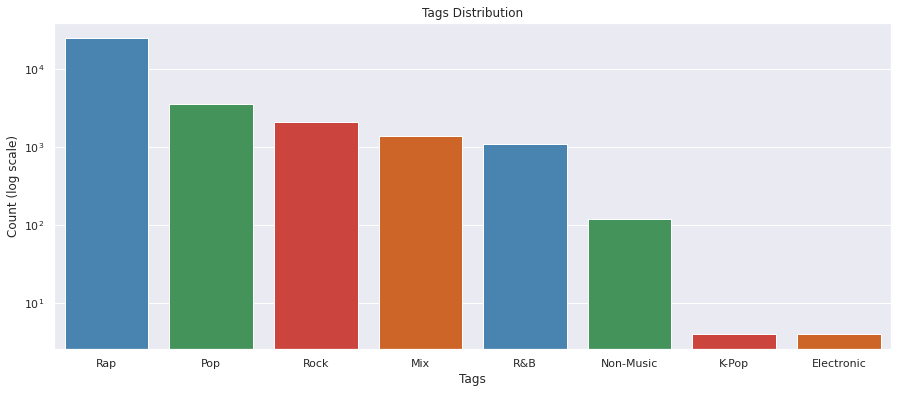

In [34]:
# Import the necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Calculate the value counts of the "tags" column
value_counts = filtered_df.groupBy('tags').count()

# Convert count column to integer
value_counts = value_counts.withColumn("count", col("count").cast("int"))

# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = value_counts.toPandas()

# Sort the DataFrame by count in descending order for better visualization
pandas_df = pandas_df.sort_values(by='count', ascending=False)

blue_color = sns.color_palette("Blues_d", 1)[0]
green_color = sns.color_palette("Greens_d", 1)[0]
red_color = sns.color_palette("Reds_d", 1)[0]
orange_color = sns.color_palette("Oranges_d", 1)[0]

# Combine the shades to create a custom palette
custom_palette = [blue_color, green_color, red_color, orange_color]


# Create a countplot using Seaborn with a logarithmic scale
sns.set(style="darkgrid")
plt.figure(figsize=(15, 6))
sns.barplot(data=pandas_df, x="tags", y="count", palette=custom_palette)

plt.xlabel("Tags")
plt.ylabel("Count (log scale)")
plt.yscale("log")  # Logarithmic scale on the y-axis
plt.title("Tags Distribution")
plt.show()

StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 33, 26, Finished, Available)

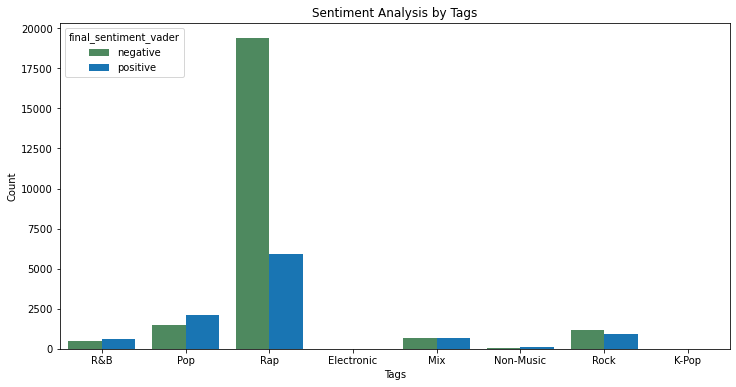

In [21]:
# Import the necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the value counts of the "final_sentiment_vader" column grouped by 'tags'
value_counts = filtered_df.select('final_sentiment_vader', 'tags').groupBy('final_sentiment_vader','tags').count()

# Convert the DataFrame to a Pandas DataFrame for easy plotting
value_counts_pandas = value_counts.toPandas()
custom_palette = ["#44935b","#007acc"]  # You can customize the colors

# Plot the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='tags', y='count', hue='final_sentiment_vader', data=value_counts_pandas,palette=custom_palette)
plt.title('Sentiment Analysis by Tags')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.show()


StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 30, 50, Finished, Available)

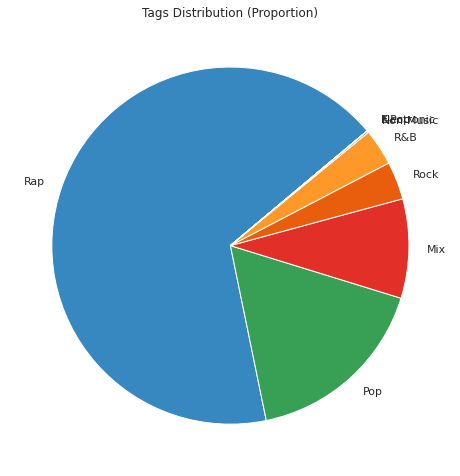

In [45]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Assuming 'filtered_df' is your PySpark DataFrame

# Calculate the sum of counts for each tag
sum_counts = filtered_df.groupBy('tags').agg({"views": "sum"})

# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = sum_counts.toPandas()

# Sort the DataFrame by sum of counts in descending order for better visualization
pandas_df = pandas_df.sort_values(by='sum(views)', ascending=False)

# Define custom colors for the pie chart
blue_color = sns.color_palette("Blues_d", 1)[0]
green_color = sns.color_palette("Greens_d", 1)[0]
red_color = sns.color_palette("Reds_d", 1)[0]
orange_color = sns.color_palette("Oranges_d", 1)[0]
yellow_color = sns.color_palette("YlOrBr", 1)[0]  # or "YlGnBu"

# Combine the shades to create a custom palette
custom_palette = [blue_color, green_color, red_color, orange_color, yellow_color]

# Set a different starting angle
startangle = 400

# Create a pie chart using matplotlib with a smaller size
plt.figure(figsize=(8, 10))
plt.pie(
    pandas_df['sum(views)'],
    labels=pandas_df['tags'],
    colors=custom_palette,
    startangle=startangle  # Adjust the starting angle
)

# Add a title to the plot
plt.title("Tags Distribution (Proportion)")

# Display the pie chart
plt.show()



# Seasonal Presence of Songs in the Market

StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 30, 48, Finished, Available)

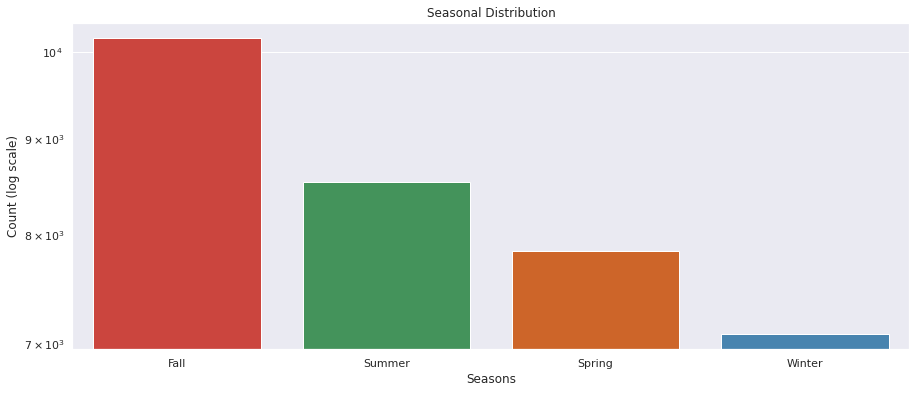

In [43]:
# Import the necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Calculate the value counts of the "tags" column
value_counts = filtered_df.groupBy('season').count()

# Convert count column to integer
value_counts = value_counts.withColumn("count", col("count").cast("int"))

# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = value_counts.toPandas()

# Sort the DataFrame by count in descending order for better visualization
pandas_df = pandas_df.sort_values(by='count', ascending=False)


green_color = sns.color_palette("Greens_d", 1)[0]
red_color = sns.color_palette("Reds_d", 1)[0]
orange_color = sns.color_palette("Oranges_d", 1)[0]
blue_color = sns.color_palette("Blues_d", 1)[0]

# Combine the shades to create a custom palette
custom_palette = [red_color,green_color,orange_color , blue_color]

# Create a countplot using Seaborn with a logarithmic scale
sns.set(style="darkgrid")
plt.figure(figsize=(15, 6))
sns.barplot(data=pandas_df, x="season", y="count", palette=custom_palette)

plt.xlabel("Seasons")
plt.ylabel("Count (log scale)")
plt.yscale("log")  # Logarithmic scale on the y-axis
plt.title("Seasonal Distribution")
plt.show()

StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 33, 27, Finished, Available)

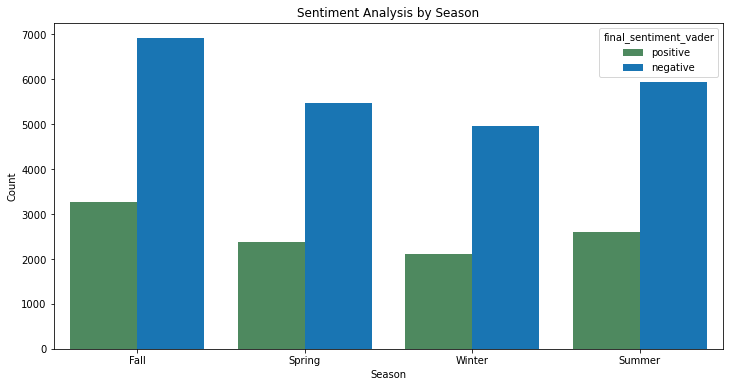

In [22]:
# Import the necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the value counts of the "final_sentiment_vader" column grouped by 'season'
value_counts_season = filtered_df.select('final_sentiment_vader', 'season').groupBy('final_sentiment_vader', 'season').count()

# Convert the DataFrame to a Pandas DataFrame for easy plotting
value_counts_season_pandas = value_counts_season.toPandas()
custom_palette = ["#44935b","#007acc"]  # You can customize the colors

# Plot the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='season', y='count', hue='final_sentiment_vader', data=value_counts_season_pandas,palette=custom_palette)
plt.title('Sentiment Analysis by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()


# Emotional Trends in the Top 15 Most Viewed American Songs: A Focus on Positive and Negative Expressions

StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 30, 44, Finished, Available)

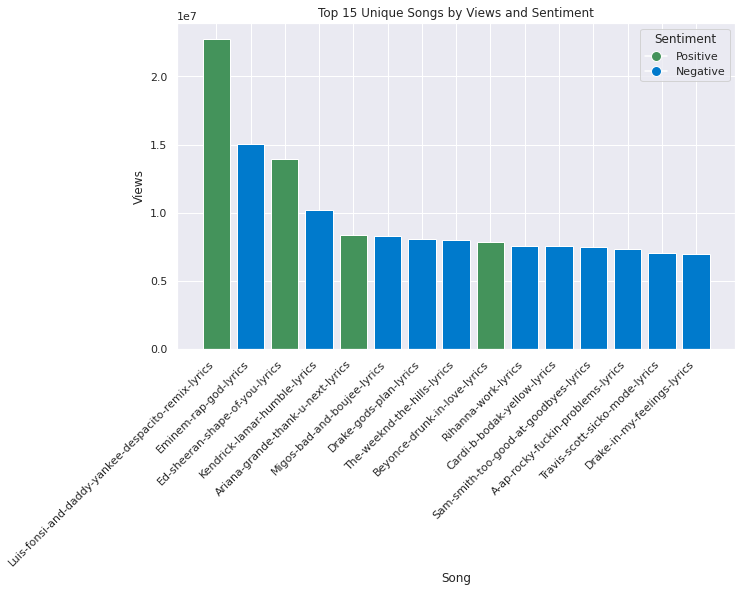

In [39]:
from pyspark.sql import functions as F

# Ensure uniqueness of songs and select the top 10 by views
top_songs_df = (
    filtered_df
    .select('song', 'final_sentiment_vader', 'views')
    .groupBy('song', 'final_sentiment_vader')
    .agg(F.max('views').alias('max_views'))
    .distinct()
    .orderBy('max_views', ascending=False)
    .limit(15)
)

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = top_songs_df.toPandas()

# Map sentiment to colors
colors = {'positive':'#44935b' , 'negative': '#007acc'}

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(pandas_df['song'], pandas_df['max_views'], color=pandas_df['final_sentiment_vader'].map(colors))

# Adding legend for colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[sentiment], markersize=10, label=sentiment.capitalize()) for sentiment in colors.keys()]
plt.legend(handles=legend_labels, title='Sentiment')

plt.title('Top 15 Unique Songs by Views and Sentiment')
plt.xlabel('Song')
plt.ylabel('Views')
plt.xticks(rotation=45, ha='right')
plt.show()

# Time Series Analysis

StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 23, 16, Finished, Available)

/tmp/ipykernel_8673/3210315423.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(pandas_df["release_date"], pandas_df["positive_count_vader"], marker='o', label='Positive Count', color='#44935b')
/tmp/ipykernel_8673/3210315423.py:32: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax2.plot_date(pandas_df["release_date"], pandas_df["negative_count_vader"], marker='o', label='Negative Count', color='#007acc')


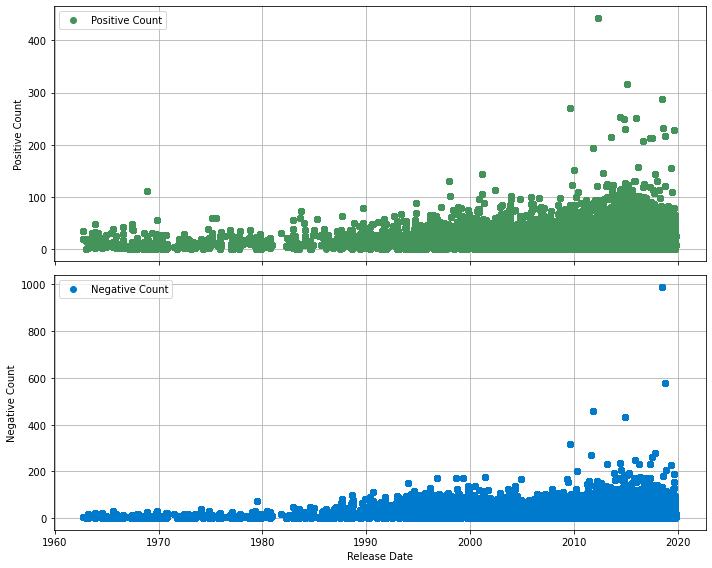

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from matplotlib import dates as mdates


spark = SparkSession.builder.appName("TimeSeriesAnalysis").getOrCreate()
filtered_df = filtered_df.withColumn("release_date", col("release_date").cast("date"))

filtered_df = filtered_df.filter(
    col("release_date").isNotNull() & col("positive_count_vader").isNotNull() & col("negative_count_vader").isNotNull()
)

date_word_counts = filtered_df.groupBy("release_date").sum("count").withColumnRenamed("sum(count)", "word_counts").orderBy("release_date")
pandas_date_word_counts = date_word_counts.toPandas()
pandas_positive_negative = filtered_df.select("release_date", "positive_count_vader", "negative_count_vader").toPandas()
pandas_df = pd.concat([pandas_date_word_counts, pandas_positive_negative], axis=0)

pandas_df["release_date"] = mdates.date2num(pandas_df["release_date"])


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))


# Plot positive counts on the second subplot
ax1.plot_date(pandas_df["release_date"], pandas_df["positive_count_vader"], marker='o', label='Positive Count', color='#44935b')
#ax1.set_xlabel('Release Date')
ax1.set_ylabel('Positive Count')
ax1.grid(True)

# Plot negative counts on the second subplot
ax2.plot_date(pandas_df["release_date"], pandas_df["negative_count_vader"], marker='o', label='Negative Count', color='#007acc')
ax2.set_xlabel('Release Date')
ax2.set_ylabel('Negative Count')
ax2.grid(True)


ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()



In [41]:
# Import the necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the value counts of the "final_sentiment_vader" column grouped by 'tags'
value_counts = filtered_df.select('release_date', 'final_sentiment_vader').groupBy('final_sentiment_vader','release_date').count()

# Show the value counts
value_counts.show()

StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 30, 46, Finished, Available)

+---------------------+------------+-----+
|final_sentiment_vader|release_date|count|
+---------------------+------------+-----+
|             negative|  2013-02-20|    9|
|             negative|  2003-11-14|   16|
|             negative|  2018-11-25|    4|
|             negative|  2012-04-23|    2|
|             negative|  2016-06-27|    5|
|             negative|  2014-05-23|   10|
|             negative|  2016-01-29|   14|
|             positive|  2010-09-27|    4|
|             positive|  2002-12-13|    5|
|             positive|  2009-09-10|    1|
|             negative|  2016-05-07|    2|
|             negative|  1988-04-18|    1|
|             negative|  2007-01-30|    2|
|             positive|  2019-04-18|    2|
|             positive|  2010-06-18|    4|
|             positive|  2014-07-08|    5|
|             positive|  1995-03-27|    1|
|             positive|  2016-12-24|    3|
|             negative|  2007-02-01|    4|
|             negative|  2009-09-07|    2|
+----------

# A Exploring the Evolution of Emotional Content in American Song Lyrics: A Time-Series Analysis

StatementMeta(90404a2c-b491-4c64-937a-8564b8338d6d, 30, 47, Finished, Available)

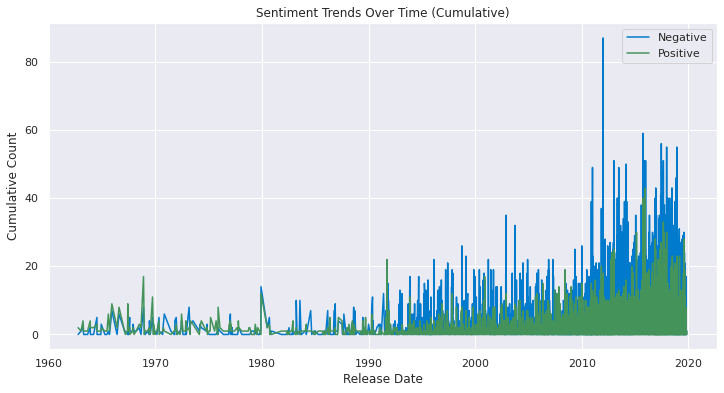

In [42]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Create a Spark session
spark = SparkSession.builder.appName("TimeSeriesAnalysis").getOrCreate()

# Assuming 'value_counts' is your DataFrame
# If not, replace 'value_counts' with your DataFrame name

# Convert 'release_date' to a timestamp type
value_counts = value_counts.withColumn('release_date', F.to_timestamp(value_counts['release_date']))

# Define a window specification for ordering by release_date
window_spec = Window.orderBy('release_date')

# Calculate cumulative sum of 'count' for each sentiment
value_counts = value_counts.withColumn('cumulative_count',
                                       F.sum('count').over(window_spec))

# Group by 'final_sentiment_vader'
grouped_counts = value_counts.groupBy('release_date', 'final_sentiment_vader').agg(F.sum('count').alias('cumulative_count'))

# Pivot the data to have separate columns for positive and negative sentiments
pivoted_counts = grouped_counts.groupBy('release_date').pivot('final_sentiment_vader').agg(F.first('cumulative_count')).fillna(0)

# Convert to Pandas for plotting
pandas_df = pivoted_counts.toPandas()

# Plot the time series
plt.figure(figsize=(12, 6))
sns.lineplot(x='release_date', y='negative', data=pandas_df, label='Negative', color='#007acc')
sns.lineplot(x='release_date', y='positive', data=pandas_df, label='Positive', color='#44935b')
plt.title('Sentiment Trends Over Time (Cumulative)')
plt.xlabel('Release Date')
plt.ylabel('Cumulative Count')
plt.legend()
plt.show()

